In [ ]:
# Copyright 2022 Google LLC. All Rights Reserved.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

#@title Setup Environment
#@markdown Install *Multi-instrument Music Synthesis with Spectrogram Diffusion* and its dependencies (may take a few minutes).

!apt-get update -qq && apt-get install -qq libfluidsynth1 build-essential libasound2-dev libjack-dev

!pip install nest-asyncio
!pip install pyfluidsynth
# pin CLU for python 3.7 compatibility
!pip install clu==0.0.7
# pin Orbax to use Checkpointer
!pip install orbax==0.0.2

!pip install note_seq==0.0.3

# install t5x
!rm -r t5x
!git clone --branch=main https://github.com/google-research/t5x
# pin T5X for python 3.7 compatibility
!cd t5x; git reset --hard 2e05ad41778c25521738418de805757bf2e41e9e; cd ..
!mv t5x t5x_tmp; mv t5x_tmp/* .; rm -r t5x_tmp
!sed -i 's:jax\[tpu\]:jax:' setup.py
!python3 -m pip install -e .

# install mt3
!rm -r mt3
!git clone --branch=main https://github.com/magenta/mt3
!mv mt3 mt3_tmp; mv mt3_tmp/* .; rm -r mt3_tmp
!python3 -m pip install -e .

# install music_spectrogram_diffusion
!rm -r music_spectrogram_diffusion
!git clone --branch=main https://github.com/magenta/music-spectrogram-diffusion
!mv music-spectrogram-diffusion/* .; rm -r music-spectrogram-diffusion
!python3 -m pip install -e .

# copy checkpoints
!gsutil -q -m cp gs://music-synthesis-with-spectrogram-diffusion/checkpoints/*.zip .
!unzip -o '*.zip'

# copy soundfont (originally from https://sites.google.com/site/soundfonts4u)
!gsutil -q -m cp gs://magentadata/soundfonts/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2 .

#Imports and Definitions

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import jax.tools.colab_tpu
# Workaround for https://github.com/googlecolab/colabtools/issues/3009
jax.tools.colab_tpu.setup_tpu(tpu_driver_version='tpu_driver-0.1dev20220801')

In [4]:
import functools
import os

import gin
import jax
import numpy as np
import jax.numpy as jnp
import tensorflow as tf

import librosa
import note_seq

In [5]:
# TensorFlow shouldn't use the GPU or TPU.
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

# Should show that JAX can see the GPU/TPU.
jax.devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=2, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=4, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=6, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(0,0,0), core_on_chip=0)]

In [6]:
# We're pinning T5X at an old version for Python 3.7 compatibility,
# but the old version hasn't been updated to the JAX API changes around
# tree_multimap, so manually patch in these aliases as a workaround.
jax.tree_util.tree_multimap = jax.tree_util.tree_map
jax.tree_multimap = jax.tree_util.tree_multimap

In [7]:
from music_spectrogram_diffusion.models.diffusion import models
from music_spectrogram_diffusion.models.diffusion import network
from music_spectrogram_diffusion.models.diffusion import feature_converters
from music_spectrogram_diffusion import datasets
from music_spectrogram_diffusion import inference
from music_spectrogram_diffusion import metrics
from music_spectrogram_diffusion import note_sequences
from music_spectrogram_diffusion import preprocessors
from music_spectrogram_diffusion import run_length_encoding
from music_spectrogram_diffusion import audio_codecs
from music_spectrogram_diffusion import tasks
from music_spectrogram_diffusion import vocabularies

import seqio
import t5
import t5x

from t5x import adafactor
from t5x import adafactor
from t5x import gin_utils
from t5x import partitioning
from t5x import trainer
from t5x import utils

from google.colab import files

import matplotlib.pyplot as plt
import IPython

SAMPLE_RATE = 16000
SF2_PATH = 'SGM-v2.01-Sal-Guit-Bass-V1.3.sf2'

/usr/local/lib/python3.7/dist-packages/orbax/checkpoint/checkpoint_manager.py:30: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTree = type(jax.tree_structure(None))
/usr/local/lib/python3.7/dist-packages/orbax/checkpoint/transform_utils.py:26: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTree = type(jax.tree_structure(None))
/usr/local/lib/python3.7/dist-packages/orbax/checkpoint/pytree_checkpointer.py:38: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTree = type(jax.tree_structure(None))
/content/t5x/partitioning.py:40: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/content/t5x/checkpoints

In [8]:
def upload_midi():
  data = list(files.upload().values())
  if len(data) > 1:
    print('Multiple files uploaded; using only one.')
  return note_seq.midi_to_note_sequence(data[0])

# Load Model

In [9]:
checkpoint_path = (
  'base_with_context/checkpoint_500000'
  # 'small_with_context/checkpoint_500000'
)


In [10]:
gin_overrides = [
    "from __gin__ import dynamic_registration",
    "from music_spectrogram_diffusion.models.diffusion import diffusion_utils",
    "diffusion_utils.ClassifierFreeGuidanceConfig.eval_condition_weight = 2.0",
    "diffusion_utils.DiffusionConfig.classifier_free_guidance = @diffusion_utils.ClassifierFreeGuidanceConfig()"
]

In [11]:
gin_file = os.path.join(checkpoint_path, '..', 'config.gin')
gin_config = inference.parse_training_gin_file(gin_file, gin_overrides)
synth_model = inference.InferenceModel(checkpoint_path, gin_config)

/content/t5x/train.py:51: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/usr/local/lib/python3.7/dist-packages/flax/linen/partitioning.py:121: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  new = set(jax.tree_leaves(new_assignment))
/usr/local/lib/python3.7/dist-packages/flax/linen/partitioning.py:122: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  existing = set(jax.tree_leaves(existing_assignments))


In [14]:
# Workaround for pjit not working on colab.
# https://github.com/google/jax/issues/8300
import t5x.partitioning
def fake_partition( self,
      fn,
      in_axis_resources,
      out_axis_resources,
      static_argnums = (),
      donate_argnums = (),
  ) -> t5x.partitioning.PjittedFnWithContext:
  # Just use jit instead of pjit. We don't need the parallelism on colab anyway.
  pjitted = jax.jit(
      fn, static_argnums=static_argnums, donate_argnums=donate_argnums)
  return t5x.partitioning.PjittedFnWithContext(pjitted, self.mesh)

synth_model.partitioner.partition = fake_partition.__get__(
    synth_model.partitioner, t5x.partitioning.PjitPartitioner)

# Upload MIDI File

In [12]:
ns = upload_midi()

note_seq.play_sequence(
    ns, synth=note_seq.midi_synth.fluidsynth, sf2_path=SF2_PATH,
    sample_rate=SAMPLE_RATE)
note_seq.plot_sequence(ns)

Saving turkish_march_short.mid to turkish_march_short.mid


# Define Task

In [13]:
vocabulary = vocabularies.vocabulary_from_codec(synth_model.codec)
note_representation_config = tasks.NoteRepresentationConfig(
          onsets_only=False, include_ties=True)

# TODO(iansimon): add this to preprocessors.py once it's less hacky
def program_to_slakh_program(program):
  # this is done very hackily, probably should use a custom mapping
  for slakh_program in sorted(preprocessors._SLAKH_CLASS_PROGRAMS.values(),
                              reverse=True):
    if program >= slakh_program:
      return slakh_program

def create_dataset(split, shuffle_files):
  del split
  del shuffle_files
  ns_sus = note_seq.apply_sustain_control_changes(ns)
  for note in ns_sus.notes:
    if not note.is_drum:
      note.program = program_to_slakh_program(note.program)
  samples = np.zeros(
      int(ns_sus.total_time * synth_model.audio_codec.sample_rate))  
  frames, frame_times = preprocessors._audio_to_frames(
      samples,
      synth_model.audio_codec.hop_size,
      synth_model.audio_codec.frame_rate)
  times, values = (
      note_sequences.note_sequence_to_onsets_and_offsets_and_programs(ns_sus))
  (events, event_start_indices, event_end_indices,
   state_events, state_event_indices) = (
       run_length_encoding.encode_and_index_events(
           state=note_sequences.NoteEncodingState(),
           event_times=times,
           event_values=values,
           encode_event_fn=note_sequences.note_event_data_to_events,
           codec=synth_model.codec,
           frame_times=frame_times,
           encoding_state_to_events_fn=(
               note_sequences.note_encoding_state_to_events)))
  return tf.data.Dataset.from_tensors({
        'inputs': frames,
        'input_times': frame_times.astype(np.float32),
        'targets': events.astype(np.int32),
        'event_start_indices': event_start_indices.astype(np.int32),
        'event_end_indices': event_end_indices.astype(np.int32),
        'state_events': state_events.astype(np.int32),
        'state_event_indices': state_event_indices.astype(np.int32),
        'sequence': ns_sus.SerializeToString()
  })

infer_task = seqio.Task(
    name='infer_full_song',
    source=seqio.FunctionDataSource(
        create_dataset,
        splits=['eval'],
        num_input_examples={'eval': 1}),
    output_features={
        'inputs': seqio.Feature(vocabulary=vocabulary),
        'targets': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
        'targets_context': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
    },
    # just take one sequence
    preprocessors=tasks.pre_cache_processor_chain(
        audio_codec=synth_model.audio_codec,
        codec=synth_model.codec,
        tokenize_fn=lambda ds, **kwargs: ds,
        note_representation_config=note_representation_config,
        split_sequences=False
    ) + tasks.split_full_song_processor_chain(
            audio_codec=synth_model.audio_codec,
            feature_context_key='targets_context'
    ) + tasks.note_representation_processor_chain(
            codec=synth_model.codec,
            note_representation_config=note_representation_config
    ) + [
        functools.partial(
            preprocessors.encode_audio,
            targets_keys=['targets'],
            context_keys=['targets_context'],
            keys_to_pad=None,
            audio_codec=synth_model.audio_codec),
        functools.partial(preprocessors.handle_too_long, skip=False),
        functools.partial(
            seqio.preprocessors.tokenize_and_append_eos,
            copy_pretokenized=True)
    ])

infer_ds = infer_task.get_dataset(
    sequence_length=synth_model.sequence_length,
    split='eval',
    use_cached=False, shuffle=False)

infer_ds_raw_batches = infer_ds.batch(1)
infer_ds_feats = synth_model.model.FEATURE_CONVERTER_CLS(pack=False)(
    infer_ds, synth_model.sequence_length)
infer_ds_batches = infer_ds_feats.batch(1)


Instructions for updating:
Use `tf.data.Dataset.random(...)`.


# Synthesize Entire Song

generated 1 segments
generated 2 segments
generated 3 segments


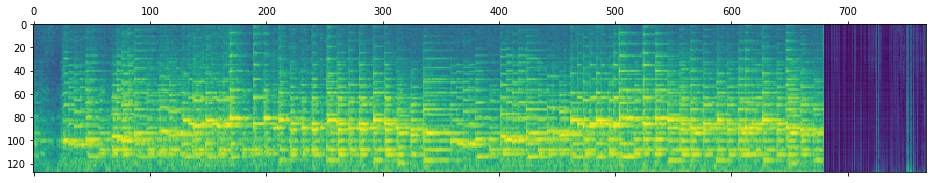

In [16]:
# Initialize previous prediction to zeros.
# We'll zero out the mask for the first prediction, so the value here doesn't
# matter.
pred_mel = np.zeros([1, synth_model.sequence_length['targets_context'],
                     synth_model.audio_codec.n_dims])

# Variables for accumulating the full song prediction.
full_pred_mel = np.zeros([1, 0, synth_model.audio_codec.n_dims], np.float32)

# Iterators over the dataset.
infer_ds_batches_iter = infer_ds_batches.as_numpy_iterator()

i = 0
while True:
  try:
    batch = next(infer_ds_batches_iter)
    # TODO(fjord): put the first-chunk logic into a library function
    batch['encoder_continuous_inputs'] = pred_mel[:1]
    if i == 0:
      # The first chunk has no previous context.
      batch['encoder_continuous_mask'] = np.zeros_like(
          batch['encoder_continuous_mask'])
    else:
      # The full song pipeline does not feed in a context feature, so the mask
      # will be all 0s after the feature converter. Because we know we're
      # feeding in a full context chunk from the previous prediction, set it
      # to all 1s.
      batch['encoder_continuous_mask'] = np.ones_like(
          batch['encoder_continuous_mask'])
    pred_mel, scores = synth_model.predict(batch)
    full_pred_mel = np.concatenate([full_pred_mel, pred_mel[:1]], axis=1)
    i += 1
    print('generated %d segments' % i)
  except StopIteration:
    break

full_pred_audio = synth_model.audio_codec.decode(full_pred_mel)

plt.matshow(np.rot90(full_pred_mel[0]))
IPython.display.Audio(full_pred_audio, rate=SAMPLE_RATE)